In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np

In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]

GSM4006644_BC1


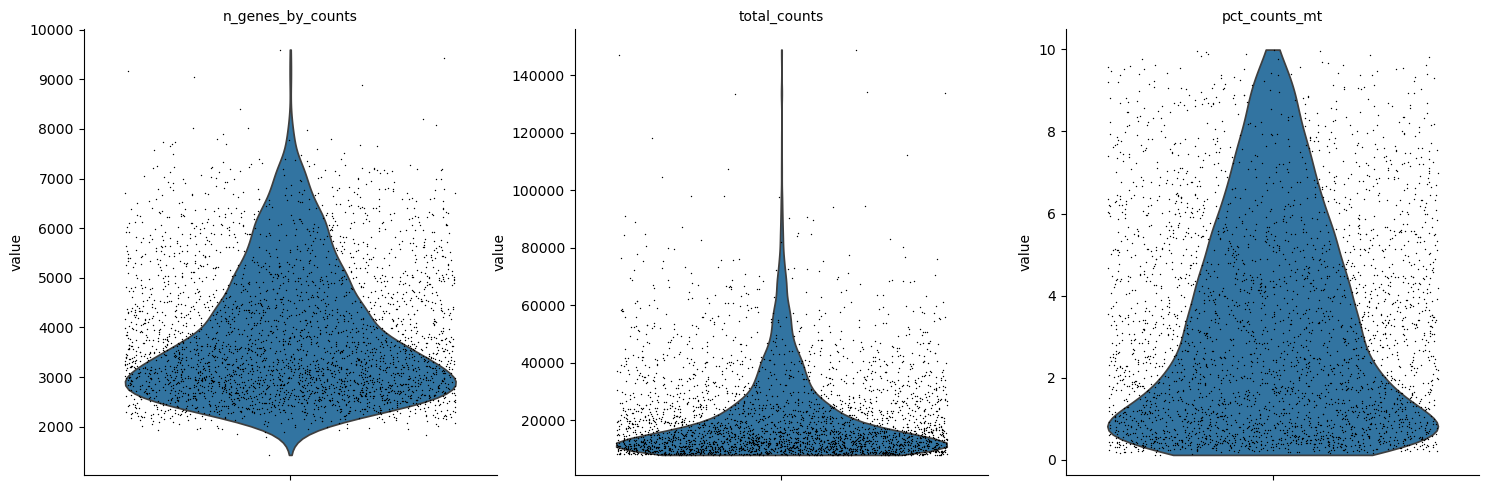

/tmp/ipykernel_35884/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


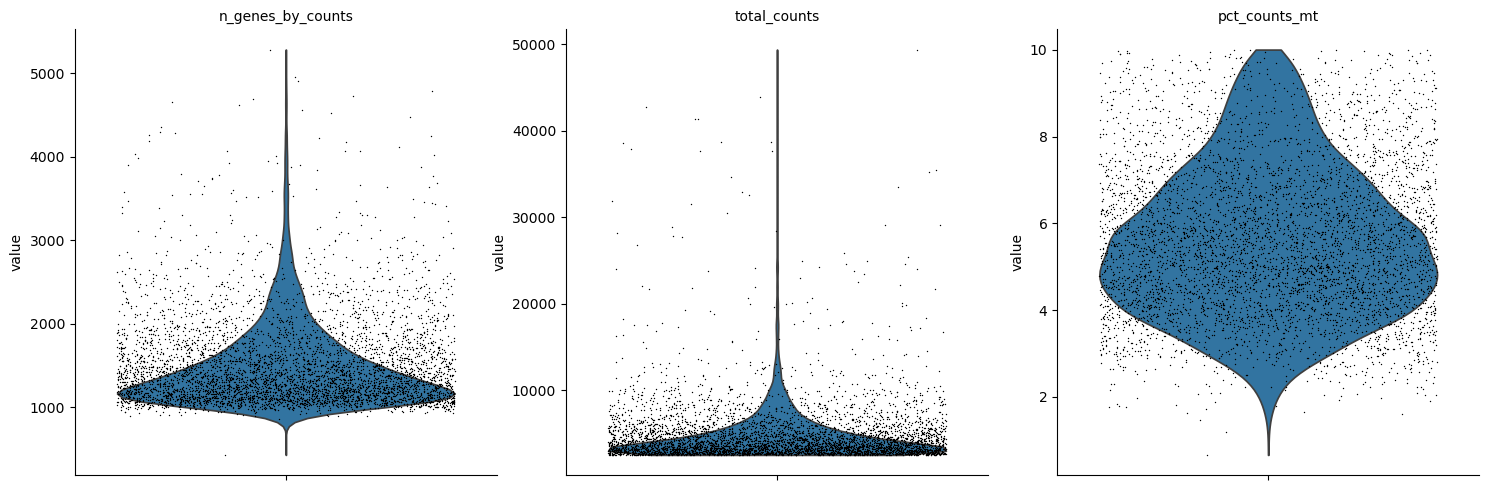

/tmp/ipykernel_35884/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


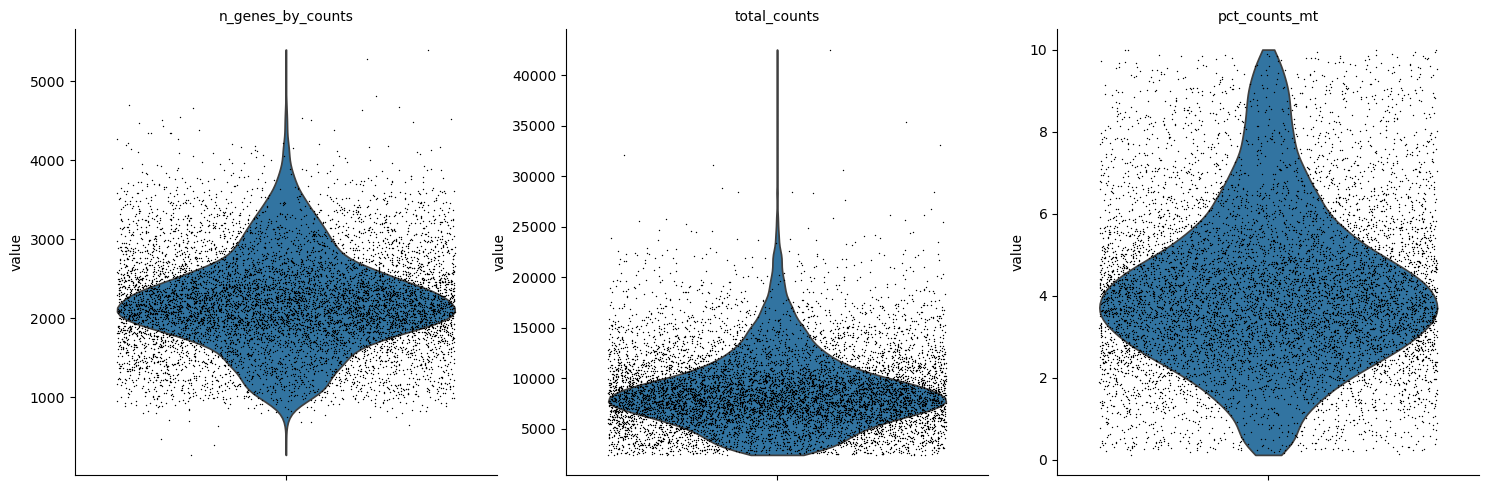

/tmp/ipykernel_35884/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


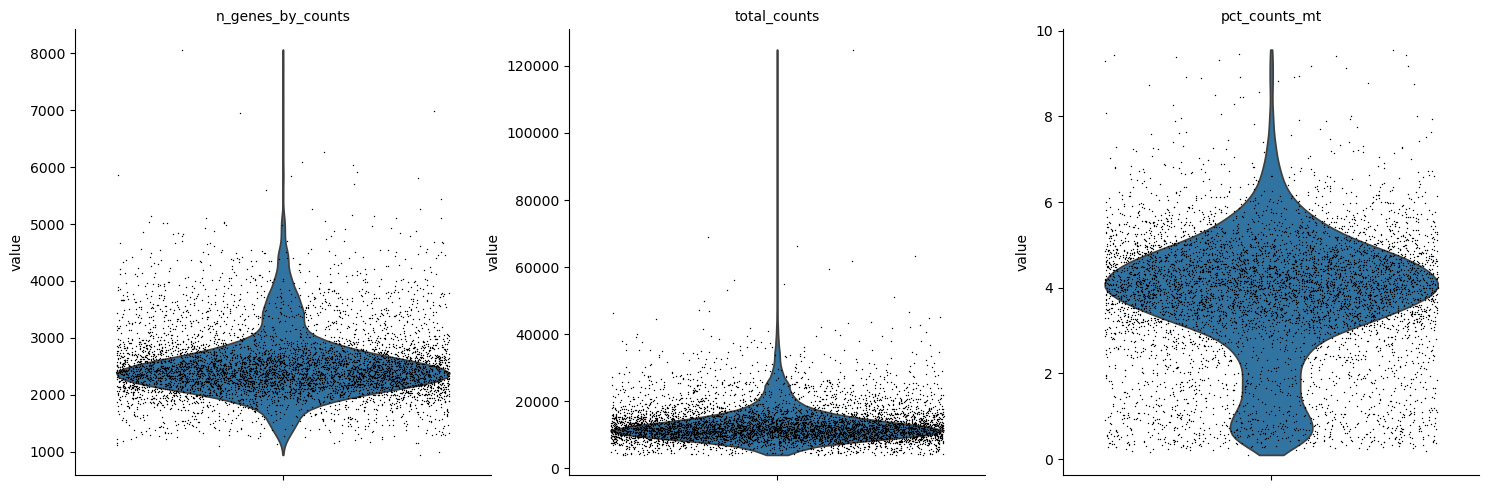

/tmp/ipykernel_35884/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


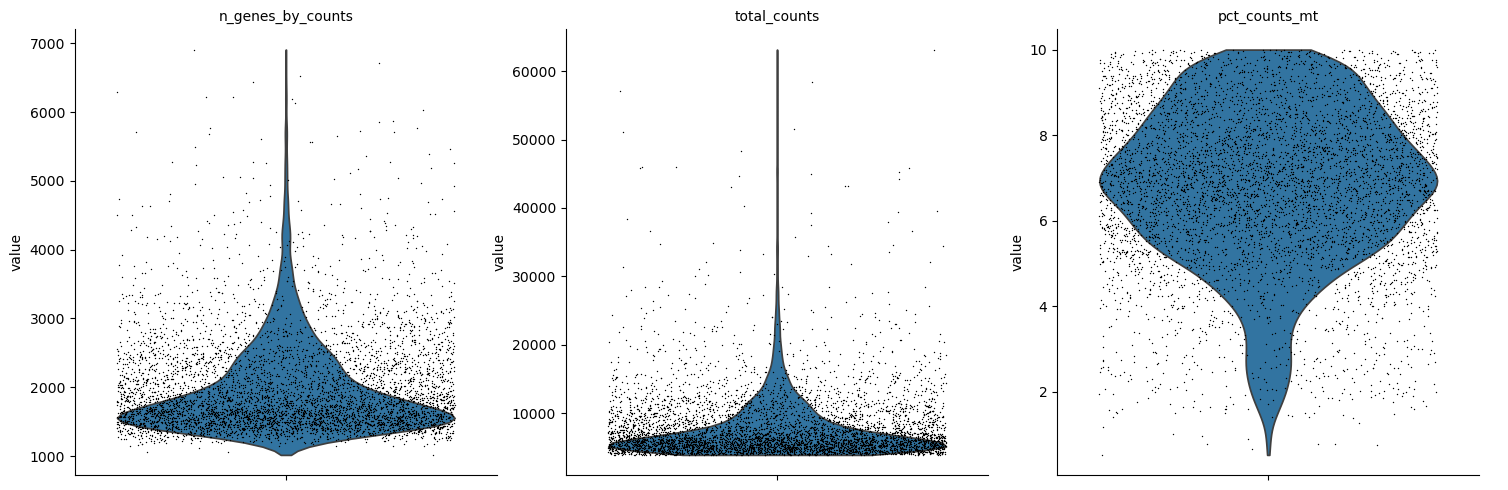

/tmp/ipykernel_35884/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)
    

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)                

/tmp/ipykernel_35884/247269705.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]
adata_non_immune

View of AnnData object with n_obs × n_vars = 27864 × 13656
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', '

In [7]:
wkdir= "/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_LINCS/"
data_year = "2020"
cell_name = "BC3C"

data_dir = os.path.join(wkdir,"00_outputs_" + data_year + "_" + cell_name)
data_file = os.path.join(data_dir, "Data_norm_" + data_year + "_" + cell_name+ ".xlsx")
Data_norm = pd.read_excel(data_file, index_col = 0)
display(Data_norm)

genes_list = Data_norm.columns.to_list()
print("Landmark genes in LINCS data:", len(genes_list), genes_list)
adata_lincs = adata_non_immune[:, adata_non_immune.var.index.isin(genes_list)]

,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
ASG002_BC3C_24H:A03,-0.191254,-0.055246,0.039596,-0.256266,-0.040419,-0.590523,-0.159396,-0.074319,0.457981,0.409608,...,0.543203,0.494266,-0.011923,-0.225931,0.285054,-0.775246,0.166031,-0.024873,0.238723,0.284204
ASG002_BC3C_24H:A04,-0.265754,-0.317496,0.118696,-0.136665,-0.301569,-0.403023,0.124804,-0.036470,0.311931,0.660457,...,-0.565096,-0.088634,0.122977,-0.047931,0.141804,0.129054,-0.028819,-0.028773,-0.253627,-0.752646
ASG002_BC3C_24H:A05,-0.181954,-0.081597,-0.210304,1.559535,-0.019019,-0.457423,0.071404,0.074080,-0.356119,0.498808,...,0.226104,-0.228034,-0.121023,-0.075331,-0.133146,0.355054,0.022831,-0.084073,0.283123,-0.894896
ASG002_BC3C_24H:A06,0.033446,0.042404,-0.150154,-0.093165,0.053180,-0.053823,0.087704,0.167681,-0.601569,0.383308,...,-0.608596,-0.228835,0.072777,0.082970,-0.570996,2.847754,-0.211670,-0.067273,0.081723,0.338704
ASG002_BC3C_24H:J13,0.204446,0.180704,0.089096,-0.054666,0.053381,0.044877,-0.277396,-0.157419,0.535681,-3.933493,...,-0.318397,0.122265,-0.134323,-0.088931,-0.067996,-0.515847,-0.005069,0.067527,0.002223,0.204904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR012_BC3C_24H:P20,0.647151,0.211700,-0.979200,0.597350,-0.375751,0.388300,0.394524,0.120151,-0.166775,-1.129125,...,-1.598475,-0.552750,0.515151,0.120800,0.082675,0.529700,0.383225,-0.207225,2.268450,-1.248500
MOAR012_BC3C_24H:P21,0.171800,0.046300,-0.145550,-0.295150,0.030849,0.420951,0.222075,0.179800,0.274724,-0.423975,...,-1.650575,0.203600,-0.003250,-0.064800,-0.037675,0.076499,0.201825,0.416875,0.287450,-0.971700
MOAR012_BC3C_24H:P22,0.648700,0.058749,-0.031700,0.408249,-0.753950,0.332200,-0.357525,-0.107650,-0.213575,0.074225,...,0.127625,0.031600,0.103250,-0.249600,0.046375,1.486200,0.440325,0.090075,-0.031650,-0.944300
MOAR012_BC3C_24H:P23,0.090499,-0.469300,-0.611800,0.873550,-0.788450,-0.097199,-0.366575,-0.490600,-0.624675,-0.009275,...,0.054676,-0.596050,0.084600,0.444700,0.431375,-0.921501,0.044926,0.716076,-0.000900,-1.106700


Landmark genes in LINCS data: 978 ['AARS', 'ABCB6', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1', 'ADGRE5', 'ADGRG1', 'ADH5', 'ADI1', 'ADO', 'ADRB2', 'AGL', 'AKAP8', 'AKAP8L', 'AKR7A2', 'AKT1', 'ALAS1', 'ALDH7A1', 'ALDOA', 'ALDOC', 'AMDHD2', 'ANKRD10', 'ANO10', 'ANXA7', 'APBB2', 'APOE', 'APP', 'APPBP2', 'ARFIP2', 'ARHGAP1', 'ARHGEF12', 'ARHGEF2', 'ARID4B', 'ARID5B', 'ARL4C', 'ARNT2', 'ARPP19', 'ASAH1', 'ASCC3', 'ATF1', 'ATF5', 'ATF6', 'ATG3', 'ATMIN', 'ATP11B', 'ATP1B1', 'ATP2C1', 'ATP6V0B', 'ATP6V1D', 'AURKA', 'AURKB', 'AXIN1', 'B4GAT1', 'BACE2', 'BAD', 'BAG3', 'BAMBI', 'BAX', 'BCL2', 'BCL7B', 'BDH1', 'BECN1', 'BHLHE40', 'BID', 'BIRC2', 'BIRC5', 'BLCAP', 'BLMH', 'BLVRA', 'BMP4', 'BNIP3', 'BNIP3L', 'BPHL', 'BRCA1', 'BTK', 'BUB1B', 'BZW2', 'C2CD2', 'C2CD2L', 'C2CD5', 'C5', 'CAB39', 'CALM3', 'CALU', 'CAMSAP2', 'CANT1', 'CAPN1', 'CARMIL1', 'CASC3', 'CASK', 'CASP10', 'CASP2', 'CASP3', 'CASP7', 'CAST', 'CAT', 'CBLB

In [8]:
adata_lincs = adata[:, adata.var.index.isin(genes_list)]

In [9]:
adata_lincs.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1
...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7


In [11]:
indices= pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_non_immune_obs.xlsx',
                     index_col=0)
indices

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,5
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,2
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,4
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1


In [13]:
adata_lincs.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1
...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7


In [18]:
adata_lincs.obs['leiden'] ='None'

In [61]:
adata_lincs.obs.loc[indices[indices['leiden'] == 3].index,'leiden'] =3

In [ ]:
luminal= ['GSM4751267_BC6', 'GSM4751268_BC7']#'GSM4006644_BC1',
basal = ['GSM4006647_BC4', 'GSM4006648_BC5']
#mibc = ['GSM4006647_BC4'] #Only basal

NMIBC = adata_lincs[adata_lincs.obs['source'].isin(nmibc), :]
nmibc_df= NMIBC.to_df()

MIBC = adata_lincs[adata_lincs.obs['source'].isin(mibc), :]
mibc_df= MIBC.to_df()


In [62]:
adata_lincs_cluster3 = adata_lincs[adata_lincs.obs['leiden'] == 3,]

In [79]:
nmibc= ['GSM4751267_BC6', 'GSM4751268_BC7']#
mibc = ['GSM4006647_BC4']
#mibc = ['GSM4006647_BC4'] #Only basal

NMIBC = adata_lincs_cluster0[adata_lincs_cluster0.obs['source'].isin(nmibc), :]
nmibc_df= NMIBC.to_df()

MIBC = adata_lincs_cluster0[adata_lincs_cluster0.obs['source'].isin(mibc), :]
mibc_df= MIBC.to_df()


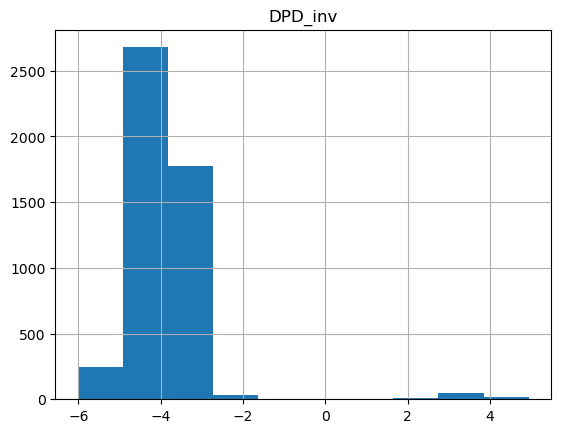

In [80]:
import cstarpy
from cstarpy.separation import CellStateTransition
cst_inv = CellStateTransition('inv',nmibc_df, mibc_df)
dpd_inv_scores=cst_inv.get_dpd()
dpd_inv_scores

dpd_inv_scores.hist()
norm_s_inv_df = pd.DataFrame(np.stack([cst_inv.n, cst_inv.s], axis=1), 
                             index=cst_inv.svm_input.data.columns, columns=["n", "s"])


In [27]:
import re

#Depmap
blca= pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_depmep/OmicsExpressionProteinCodingGenesTPMLogp1.csv',index_col=0)

blca.columns = [re.sub(r'\s*\(.*?\)', '', s) for s in list(blca.columns)]
blca

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,H3C2,H3C3,AC098582.1,DUS4L-BCAP29,C8orf44-SGK3,ELOA3B,NPBWR1,ELOA3D,ELOA3,CDR1
ACH-001113,4.331992,0.000000,7.364660,2.792855,4.471187,0.028569,1.226509,3.044394,6.500005,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.000000,0.275007,0.0,0.000000,0.000000
ACH-001289,4.567424,0.584963,7.106641,2.543496,3.504620,0.000000,0.189034,3.813525,4.221877,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001339,3.150560,0.000000,7.379118,2.333424,4.228049,0.056584,1.310340,6.687201,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.000000,0.084064,0.0,0.000000,0.042644
ACH-001538,5.085340,0.000000,7.154211,2.545968,3.084064,0.000000,5.868390,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.000000,0.028569,0.0,0.000000,0.000000
ACH-000242,6.729417,0.000000,6.537917,2.456806,3.867896,0.799087,7.208478,5.570159,7.127117,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.000000,0.464668,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000285,0.056584,0.000000,6.604368,3.266037,4.973152,0.411426,0.097611,0.704872,4.829850,5.178715,...,2.229588,0.084064,1.310340,3.039138,0.344828,0.000000,0.000000,0.0,0.475085,0.042644
ACH-002669,3.111031,0.000000,7.031329,1.541019,3.664483,0.014355,3.624101,6.805421,4.472488,4.397118,...,0.189034,0.400538,0.356144,1.327687,0.000000,0.000000,0.014355,0.0,0.000000,0.000000
ACH-001858,4.390943,0.000000,7.013239,1.887525,3.252476,0.028569,3.286881,6.902194,5.410748,3.401903,...,1.097611,0.400538,0.613532,1.992768,0.704872,0.000000,1.464668,0.0,0.000000,0.526069
ACH-001997,5.057450,0.000000,7.815191,2.538538,3.893362,0.028569,4.079805,6.971659,4.469886,3.463361,...,0.831877,0.847997,1.292782,2.153805,0.687061,0.000000,0.000000,0.0,0.000000,0.000000


In [28]:
def compute_invasiveness_score(blca, vector, vector_name='n', score_name='invasiveness'):
    """
    Compute invasiveness score via dot product between expression and gene vector.

    Parameters:
        blca (pd.DataFrame): Gene expression DataFrame (samples as rows, genes as columns).
        vector (pd.DataFrame or pd.Series): Gene weights with gene names as index.
        vector_name (str): Column name to extract from DataFrame if `vector` is a DataFrame.
        score_name (str): Name for the output score column.

    Returns:
        pd.DataFrame: DataFrame with index as blca samples and one column: score_name.
    """
    # Align vector and expression matrix by intersecting genes
    common_genes = blca.columns.intersection(vector.index)
    common_genes = common_genes.intersection(genes_list)
    print(len(common_genes))
    print(common_genes)
    vector_aligned = vector.loc[common_genes]
    print(vector_aligned)
    if isinstance(vector_aligned, pd.DataFrame):
        vector_aligned = vector_aligned[vector_name]

    blca_aligned = blca[common_genes]
    print(blca_aligned)
    # Compute dot product
    scores = blca_aligned.dot(vector_aligned)

    # Wrap in DataFrame
    score_df = pd.DataFrame(scores, columns=[score_name])
    
    return score_df


In [29]:
norm_s_inv_df

,n,s
Gene,,
TSPAN6,-0.048187,-0.009261
SCYL3,0.011760,0.001577
BAD,0.004674,0.025523
LAP3,0.003473,0.009701
SNX11,-0.004320,0.006820
...,...,...
RBM15B,0.006490,0.004367
MRPL12,0.038583,0.068719
IKBKE,-0.010708,0.005132


In [81]:
DPD_df = compute_invasiveness_score(blca, norm_s_inv_df, vector_name='n', score_name='invasiveness')
display(DPD_df)


907
Index(['TSPAN6', 'SCYL3', 'BAD', 'LAP3', 'SNX11', 'CASP10', 'CFLAR', 'FKBP4',
       'RBM6', 'SLC25A13',
       ...
       'TWF2', 'HOXA10', 'LYN', 'CHMP4A', 'POLG2', 'RBM15B', 'MRPL12', 'IKBKE',
       'DUSP14', 'PIP4K2B'],
      dtype='object', length=907)
                n         s
TSPAN6  -0.038066 -0.032302
SCYL3    0.016778  0.009747
BAD     -0.001195 -0.001390
LAP3     0.000767  0.001300
SNX11   -0.004134 -0.002430
...           ...       ...
RBM15B  -0.008134 -0.003177
MRPL12  -0.004951  0.006102
IKBKE    0.006064  0.009479
DUSP14  -0.005419 -0.008039
PIP4K2B -0.010717 -0.003124

[907 rows x 2 columns]
              TSPAN6     SCYL3       BAD      LAP3     SNX11    CASP10  \
ACH-001113  4.331992  2.792855  5.159871  4.783457  4.218781  2.000000   
ACH-001289  4.567424  2.543496  5.543805  6.333782  4.289097  0.286881   
ACH-001339  3.150560  2.333424  4.549053  6.161081  4.205549  1.207893   
ACH-001538  5.085340  2.545968  5.537917  5.244887  3.438293  2.704872   
ACH-000

,invasiveness
ACH-001113,-17.277276
ACH-001289,-16.062618
ACH-001339,-17.513587
ACH-001538,-16.850394
ACH-000242,-19.885892
...,...
ACH-000285,-15.698748
ACH-002669,-16.842390
ACH-001858,-18.380683
ACH-001997,-18.129903


In [82]:
cell_line_ids=['ACH-000142','ACH-000593','ACH-000396','ACH-000242','ACH-000384',
               'ACH-000018','ACH-000724']

DPD_cell_lines= DPD_df.loc[cell_line_ids]
DPD_cell_lines['cell_line_name']=['CAL29','BC3C','J82','RT4','SW780','T24','HT1376']
DPD_cell_lines

,invasiveness,cell_line_name
ACH-000142,-17.158406,CAL29
ACH-000593,-17.279006,BC3C
ACH-000396,-17.334123,J82
ACH-000242,-19.885892,RT4
ACH-000384,-18.945312,SW780
ACH-000018,-15.963382,T24
ACH-000724,-18.107623,HT1376


In [ ]:
pd.to_pickle(dpd_inv_scores,os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm',"dpd_lincs_scR_inv_blca_cluster1.pkl"))
pd.to_pickle(norm_s_inv_df,os.path.join('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm',"stv_lincs_scR_inv_blca_cluster1.pkl"))

In [ ]:
nmibc= ['GSM4751267_BC6', 'GSM4751268_BC7']#'GSM4006644_BC1',
mibc = ['GSM4006647_BC4', 'GSM4006648_BC5']
#mibc = ['GSM4006647_BC4'] #Only basal

NMIBC = adata_lincs[adata_lincs.obs['source'].isin(nmibc), :]
nmibc_df= NMIBC.to_df()

MIBC = adata_lincs[adata_lincs.obs['source'].isin(mibc), :]
mibc_df= MIBC.to_df()
